# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import random as rd
import datetime

#Viz
import matplotlib.pyplot as plt
import seaborn as sns

#Time Series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

#Ignore Warning
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
sales = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
item_cat = pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

# Process Data

In [3]:
#Convertingg date to datetime
sales['date'] = pd.to_datetime(sales['date'])

In [4]:
monthly_sales = sales.groupby(['date_block_num','shop_id','item_id'])['date','item_price','item_cnt_day'].agg({"date":["min","max"],"item_price":"mean","item_cnt_day":"sum"})

In [5]:
x = items.groupby(['item_category_id']).count()
x = x.rename(columns = {'item_id':'total_item_count'})
x = x.sort_values(by='total_item_count',ascending=False)
x = x.iloc[0:10].reset_index()

plt.figure(figsize=(8,4))
sns.barplot(x.item_category_id,x.total_item_count, alpha = 0.8)
plt.title("Item category to Item Count")
plt.xlabel("Item Category")
plt.ylabel("Item Count")
plt.show()

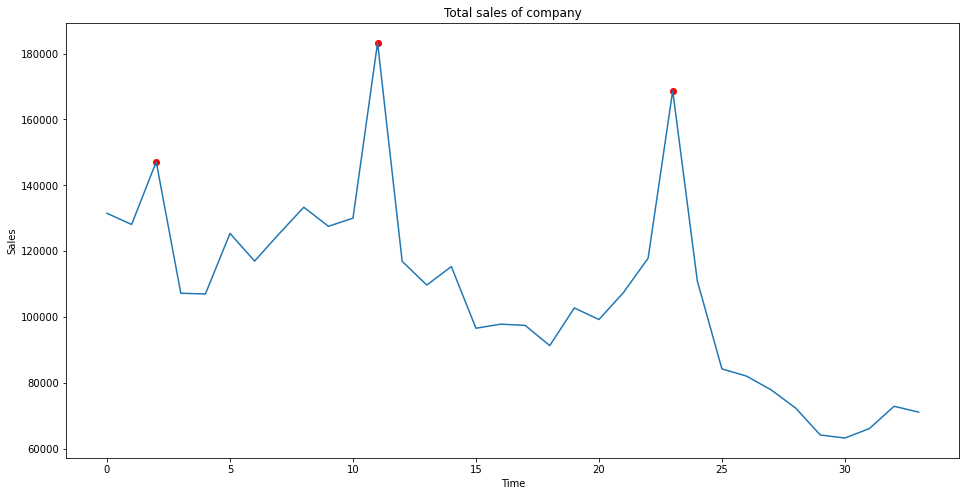

In [6]:
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
plt.figure(figsize=(16,8))
plt.title('Total sales of company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.scatter(ts[ts > 140000].index,ts[ts > 140000],color='red')

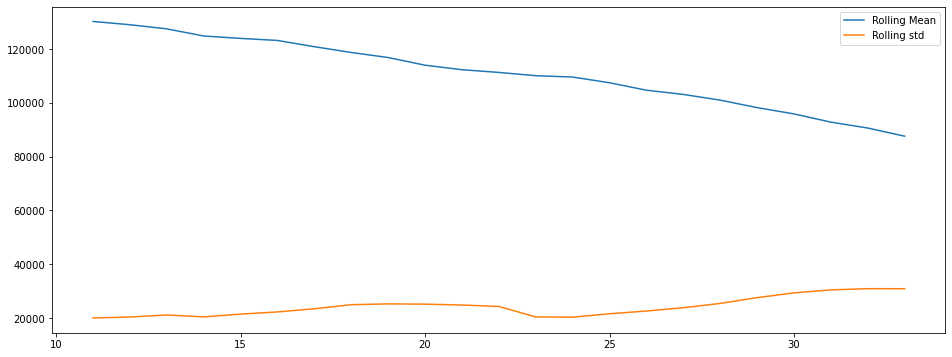

In [7]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label="Rolling Mean")
plt.plot(ts.rolling(window=12,center=False).std(), label='Rolling std')
plt.legend()

Above graph signify that data is not stationary

In [8]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(ts.values, freq=12,model='multiplicative')
fig = res.plot()

In [9]:
res = sm.tsa.seasonal_decompose(ts.values, freq=12,model='additive')
fig = res.plot()

In [10]:
def test_stationarity(timeseries):
    print("Results of Dicky-Fuller Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput  = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value',
                                              'Lags Used', 'Number of Observation Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [11]:
test_stationarity(ts)

Results of Dicky-Fuller Test:
Test Statistic                -2.395704
p-value                        0.142953
Lags Used                      0.000000
Number of Observation Used    33.000000
Critical Value (1%)           -3.646135
Critical Value (5%)           -2.954127
Critical Value (10%)          -2.615968
dtype: float64


In [12]:
from pandas import Series as Series

def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

def inverse_difference(last_ob, value):
    return value + last_ob

[]

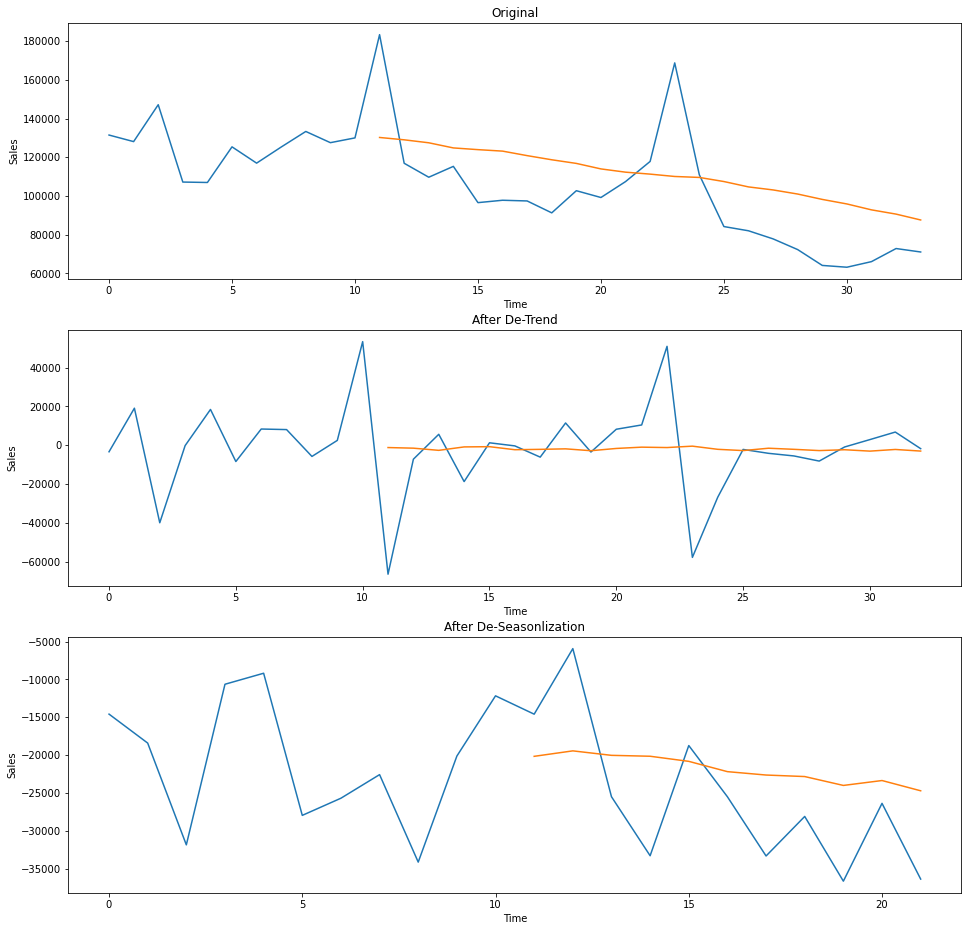

In [13]:
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.plot(ts.rolling(window=12,center=False).mean())
plt.subplot(312)
plt.title('After De-Trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = difference(ts)
plt.plot(new_ts)
plt.plot(new_ts.rolling(window=12,center=False).mean())
plt.plot()

plt.subplot(313)
plt.title("After De-Seasonlization")
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts  = difference(ts,12)
plt.plot(new_ts)
plt.plot(new_ts.rolling(window=12,center=False).mean())
plt.plot()

In [14]:
test_stationarity(difference(ts))

Results of Dicky-Fuller Test:
Test Statistic               -1.363622e+01
p-value                       1.686395e-25
Lags Used                     1.000000e+01
Number of Observation Used    2.200000e+01
Critical Value (1%)          -3.769733e+00
Critical Value (5%)          -3.005426e+00
Critical Value (10%)         -2.642501e+00
dtype: float64


In [15]:
def tstplot(y, lags=None, figsize=(10,8),style='bmh',title=''):
    if not isinstance(y,pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize = figsize)
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout,(1,0))
        pacf_ax = plt.subplot2grid(layout,(1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))
        
        y.plot(ax = ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax,alpha=0.5)
        sm.qqplot(y,line='s',ax=qq_ax)
        qq_ax.set_title("QQ plot")
        scs.probplot(y, sparams=(y.mean(),y.std()),plot=pp_ax)
        plt.tight_layout()
        return

In [16]:
np.random.seed(1)
n_samples = int(1000)
a=0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a * x[t-1] + w[t]

limit=12
_ = tstplot(x,lags = limit, title="AR(1)process")

In [17]:
n = int(1000)
alphas = np.array([.444,.333])
betas = np.array([0.0])

ar = np.r_[1,-alphas]
ma = np.r_[1,betas]

ar2 = smt.arma_generate_sample(ar=ar,ma = ma,nsample=n)
_ = tstplot(ar2,lags=12,title="AR(2) process")

In [18]:
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.8])
ar = np.r_[1,-alphas]
ma = np.r_[1,betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
limit=12
_ = tstplot(ma1, lags=limit, title="MA(1) process")

In [19]:
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6,0.4])
ar = np.r_[1,-alphas]
ma = np.r_[1,betas]
ma3 = smt.arma_generate_sample(ar=ar,ma=ma,nsample=n)
_ = tstplot(ma3,lags=12,title="MA(2) process")

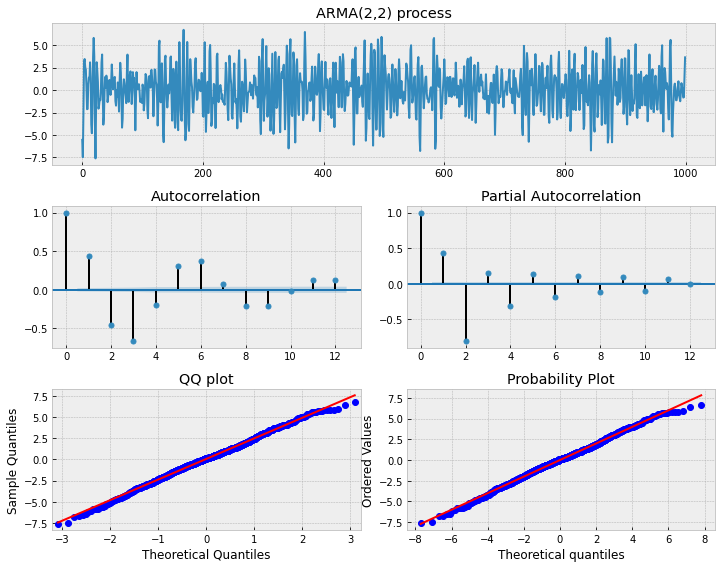

In [20]:
max_lag = 12
n = int(1000)
burn = n // 10
alphas = np.array([0.8,-0.65])
betas = np.array([0.5,-0.7])
ar = np.r_[1,-alphas]
ma = np.r_[1,betas]
arma22 = smt.arma_generate_sample(ar=ar,ma=ma,nsample=n,burnin=burn)
_ = tstplot(arma22,lags=max_lag,title="ARMA(2,2) process")

In [21]:
best_aic = np.inf
best_order = None
best_mdl = None
rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values,order=(i,j)).fit(method='mle',trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i,j)
                best_mdl = tmp_mdl
        except Exception as e:
            print(e)

print('aic: {:6.5f} | order:{}'.format(best_aic,best_order))

Estimation requires the inclusion of least one AR term, MA term, a constant or an exogenous variable.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a differ

In [22]:
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.index = pd.date_range(start='2013-01-01',end='2015-10-01',freq='MS')
ts = ts.reset_index()
ts.head()

index  item_cnt_day
0 2013-01-01      131479.0
1 2013-02-01      128090.0
2 2013-03-01      147142.0
3 2013-04-01      107190.0
4 2013-05-01      106970.0

In [23]:
from fbprophet import Prophet
ts.columns = ['ds','y']
model = Prophet(yearly_seasonality = True)
model.fit(ts)

In [24]:
future = model.make_future_dataframe(periods = 5,freq='MS')
forecast = model.predict(future)
forecast[['ds','yhat',
         'yhat_lower','yhat_upper']].tail()

ds           yhat     yhat_lower     yhat_upper
34 2015-11-01   83193.957416   80066.687810   86296.542508
35 2015-12-01  125513.063181  122545.143073  128540.039514
36 2016-01-01   75625.688717   72407.419799   78648.179382
37 2016-02-01   40109.144632   36788.337983   43235.359461
38 2016-03-01   76664.084927   73555.397498   79673.277914

In [25]:
_ = model.plot(forecast)

In [26]:
_ = model.plot_components(forecast)

In [27]:
total_sales = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
dates = pd.date_range(start='2013-01-01',end='2015-10-01',freq='MS')
total_sales.index = dates
total_sales.head()

2013-01-01    131479.0
2013-02-01    128090.0
2013-03-01    147142.0
2013-04-01    107190.0
2013-05-01    106970.0
Freq: MS, Name: item_cnt_day, dtype: float64

In [28]:
monthly_sales = sales.groupby(['shop_id','item_id','date_block_num'])['item_cnt_day'].sum()
monthly_sales = monthly_sales.unstack(-1).fillna(0)
monthly_sales = monthly_sales.T
dates = pd.date_range(start='2013-01-01',end='2015-10-01',freq='MS')
monthly_sales.index = dates
monthly_sales = monthly_sales.reset_index()
monthly_sales.head()

shop_id      index     0                                             ...  \
item_id               30    31    32   33    35   36   40   42   43  ...   
0       2013-01-01   0.0   0.0   6.0  3.0   1.0  0.0  0.0  0.0  1.0  ...   
1       2013-02-01  31.0  11.0  10.0  3.0  14.0  1.0  1.0  1.0  0.0  ...   
2       2013-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
3       2013-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
4       2013-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   

shop_id    59                                                        
item_id 22144 22145 22150 22151 22153 22154 22155 22162 22164 22167  
0         0.0   0.0   0.0   2.0   0.0   1.0   0.0   0.0   0.0   0.0  
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 424125 columns]

In [29]:
import time
start_time = time.time()

forecastsDict = {}
for node in range(len(monthly_sales)):
    nodeToForecast = pd.concat([monthly_sales.iloc[:,0], monthly_sales.iloc[:,node+1]],axis=1)
    nodeToForecast.columns = ['ds', 'y']
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality = True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods=1,freq='MS')
    forecastsDict[node] = m.predict(future)
    if node == 10:
        end_time = time.time()
        print('forecasting for ',node,'th node and took',end_time - start_time,"s")
        break

forecasting for  10 th node and took 31.253103733062744 s


In [30]:
monthly_shop_sales = sales.groupby(['date_block_num','shop_id'])['item_cnt_day'].sum()
monthly_shop_sales = monthly_shop_sales.unstack(level=1)
monthly_shop_sales = monthly_shop_sales.fillna(0)
monthly_shop_sales.index = dates
monthly_shop_sales = monthly_shop_sales.reset_index()
monthly_shop_sales.head()

shop_id      index       0       1       2      3       4       5       6  \
0       2013-01-01  5578.0  2947.0  1146.0  767.0  2114.0     0.0  3686.0   
1       2013-02-01  6127.0  3364.0   488.0  798.0  2025.0   877.0  4007.0   
2       2013-03-01     0.0     0.0   753.0  959.0  2060.0  1355.0  4519.0   
3       2013-04-01     0.0     0.0   583.0  647.0   285.0  1008.0  3168.0   
4       2013-05-01     0.0     0.0   553.0  710.0  1211.0  1110.0  3022.0   

shop_id       7       8  ...      50      51      52      53      54     55  \
0        2495.0  1463.0  ...  3406.0  2748.0  1812.0  2055.0  9386.0    0.0   
1        2513.0  1156.0  ...  3054.0  2284.0  1737.0  1906.0  8075.0    0.0   
2        2460.0   977.0  ...  3610.0  2605.0  2034.0  2365.0  9488.0    0.0   
3        1540.0    -1.0  ...  2740.0  1945.0  1446.0  1515.0  6726.0    0.0   
4        1647.0     0.0  ...  2839.0  2243.0  1482.0  1767.0  7006.0  852.0   

shop_id      56      57      58      59  
0        3238.0     0.0     0.0  2017.0  
1        2655.0     0.0     0.0  1897.0  
2        3099.0  6586.0  3773.0  2028.0  
3        2153.0  5493.0  2831.0  1388.0  
4        2140.0  5233.0  2308.0  1374.0  

[5 rows x 61 columns]

In [31]:
start_time = time.time()

forecastDict = {}
for node in range(len(monthly_shop_sales)):
    nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], monthly_shop_sales.iloc[:,node+1]],axis=1)
    nodeToForecast.columns = ['ds', 'y']
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1,freq='MS')
    forecastDict[node] = m.predict(future)

In [32]:
nCols = len(list(forecastDict.keys())) + 1
for key in range(0,nCols-1):
    f1 = np.array(forecastDict[key].yhat)
    f2 = f1[:,np.newaxis]
    if key == 0:
        predictions = f2.copy()
    else:
        predictions = np.concatenate((predictions,f2),axis=1)

In [33]:
predictions_unknown = predictions[-1]
predictions_unknown

array([  240.81393204,   116.28589275,  1107.78682599,   888.86026388,
        1465.17303431,  1311.88427115,  2553.96936873,  1874.98195159,
        -103.61300882,   581.58037786,   706.7584699 ,    29.36442879,
        3684.86252823,  -533.01327161,  1125.91098768,  2102.61611136,
        1235.63309739,  1620.531595  ,  1507.99916018,  1901.9932538 ,
        -681.46090572,  2090.00319908,  1744.75630904,  -742.48402473,
        2329.36463879,  6642.37729189,  1533.46139986,  6841.03565345,
        4470.31106098,   145.57284766,   296.75210806,  8209.01135323,
       -1266.81428446,   775.5725287 ])

*Shop_Id
*Item_Id
*Item_Category
*Date_Block_Num
TARGET-> SHOP_ID,ITEM_ID -> sales

1. Apply Top-Down approach and predict total sales per shop
2. For each shop
    * Calculate weight of item = total_item sold by this item id / (total ietms sold by shop)
    * Multiply this weight to forecast to predict contribution of this item id

In [34]:
start_time = time.time()
forecastDict = {}
for node in range(0,len(monthly_shop_sales.columns)-1):
    nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], monthly_shop_sales.iloc[:,node+1]],axis=1)
    nodeToForecast.columns = ['ds', 'y']
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1,freq='MS')
    forecastDict[node] = m.predict(future)
    print('Processed Node : ',node,'Time : ',(time.time() - start_time))

Processed Node :  0 Time :  2.7598114013671875
Processed Node :  1 Time :  5.615754127502441
Processed Node :  2 Time :  8.710905313491821
Processed Node :  3 Time :  11.748396396636963
Processed Node :  4 Time :  14.741447925567627
Processed Node :  5 Time :  17.554785013198853
Processed Node :  6 Time :  20.436978816986084
Processed Node :  7 Time :  23.36931037902832
Processed Node :  8 Time :  26.29398226737976
Processed Node :  9 Time :  29.334071397781372
Processed Node :  10 Time :  32.12418723106384
Processed Node :  11 Time :  34.907511472702026
Processed Node :  12 Time :  37.84250211715698
Processed Node :  13 Time :  40.59934091567993
Processed Node :  14 Time :  43.47064471244812
Processed Node :  15 Time :  46.57185411453247
Processed Node :  16 Time :  49.462646484375
Processed Node :  17 Time :  52.320942878723145
Processed Node :  18 Time :  55.08253502845764
Processed Node :  19 Time :  58.02043151855469
Processed Node :  20 Time :  60.704527616500854
Processed Node :

In [35]:
sales_shop = sales.groupby(['shop_id'])['item_cnt_day'].sum()

In [36]:
sales_shop = sales_shop.fillna(0)
sales_shop = sales_shop.reset_index()
sales_shop.head()

shop_id  item_cnt_day
0        0       11705.0
1        1        6311.0
2        2       30620.0
3        3       28355.0
4        4       43942.0

In [37]:
sales_shop_item = sales.groupby(['shop_id','item_id'])['item_cnt_day'].sum()
sales_shop_item = sales_shop_item.fillna(0)
sales_shop_item = sales_shop_item.reset_index()
sales_shop_item.head()

shop_id  item_id  item_cnt_day
0        0       30          31.0
1        0       31          11.0
2        0       32          16.0
3        0       33           6.0
4        0       35          15.0

In [38]:
merged_salesc = pd.merge(sales,items,on='item_id')

In [39]:
merged_salesc

date  date_block_num  shop_id  item_id  item_price  \
0       2013-02-01               0       59    22154       999.0   
1       2013-01-23               0       24    22154       999.0   
2       2013-01-20               0       27    22154       999.0   
3       2013-02-01               0       25    22154       999.0   
4       2013-03-01               0       25    22154       999.0   
...            ...             ...      ...      ...         ...   
2935844 2015-10-17              33       25     8428       249.0   
2935845 2015-01-10              33       25     7903     12198.0   
2935846 2015-10-29              33       25     7610      2890.0   
2935847 2015-10-22              33       25     7635      2100.0   
2935848 2015-01-10              33       25     7640      4040.0   

         item_cnt_day                                          item_name  \
0                 1.0                                  ЯВЛЕНИЕ 2012 (BD)   
1                 1.0                                  ЯВЛЕНИЕ 2012 (BD)   
2                 1.0                                  ЯВЛЕНИЕ 2012 (BD)   
3                 1.0                                  ЯВЛЕНИЕ 2012 (BD)   
4                 1.0                                  ЯВЛЕНИЕ 2012 (BD)   
...               ...                                                ...   
2935844           1.0                       АХ, ВОДЕВИЛЬ, ВОДЕВИЛЬ (rem)   
2935845           1.0  XBOX 360 S 250GB CONSOLE/KINECT BUNDLE KUNG FU...   
2935846           1.0      WARHAMMER ACCESSORIES: Khorne Dice арт. 65-13   
2935847           1.0  WARHAMMER MINIATURES: Dark Elf Doomfire Warloc...   
2935848           1.0  WARHAMMER MINIATURES: Stormcast Eternals Palad...   

         item_category_id  
0                      37  
1                      37  
2                      37  
3                      37  
4                      37  
...                   ...  
2935844                40  
2935845                15  
2935846                64  
2935847                64  
2935848                64  

[2935849 rows x 8 columns]

In [40]:
merged_salesc_category = merged_salesc.groupby(['shop_id','item_category_id'])['item_cnt_day'].sum()
merged_salesc_category = merged_salesc_category.fillna(0)
merged_salesc_category = merged_salesc_category.reset_index()
merged_salesc_category.head()

shop_id  item_category_id  item_cnt_day
0        0                 0           1.0
1        0                 1           1.0
2        0                 2         105.0
3        0                 3          52.0
4        0                 4          38.0

In [41]:
merged_salesc_category_item = merged_salesc.groupby(['item_category_id'])['item_cnt_day'].sum()
merged_salesc_category_item = merged_salesc_category_item.fillna(0)
merged_salesc_category_item = merged_salesc_category_item.reset_index()
merged_salesc_category_item.tail()

item_category_id  item_cnt_day
79                79       15830.0
80                80        6136.0
81                81         965.0
82                82       10437.0
83                83       12032.0

In [42]:
merged_salesc_category_item_id = merged_salesc.groupby(['item_category_id','item_id'])['item_cnt_day'].sum()
merged_salesc_category_item_id = merged_salesc_category_item_id.fillna(0)
merged_salesc_category_item_id = merged_salesc_category_item_id.reset_index()
merged_salesc_category_item_id.tail(50)

item_category_id  item_id  item_cnt_day
21757                78    19373           1.0
21758                78    19374           1.0
21759                78    19375           4.0
21760                78    19424           8.0
21761                78    19425          61.0
21762                78    19426          72.0
21763                78    19427           3.0
21764                78    19428           1.0
21765                78    19429           1.0
21766                78    19940           2.0
21767                78    20004          10.0
21768                78    20326           3.0
21769                78    20960           3.0
21770                79    17717       15830.0
21771                80     9244         651.0
21772                80     9246        1034.0
21773                80     9248        1704.0
21774                80     9250        1512.0
21775                80     9252         553.0
21776                80     9254         682.0
21777                81    13346         550.0
21778                81    13347           2.0
21779                81    13349           8.0
21780                81    13352          76.0
21781                81    13355         324.0
21782                81    13356           1.0
21783                81    13358           4.0
21784                82    13344        2013.0
21785                82    13345        2451.0
21786                82    13348           9.0
21787                82    13350        1064.0
21788                82    13351        2080.0
21789                82    13353           4.0
21790                82    13354        2803.0
21791                82    13357          13.0
21792                83    22085           5.0
21793                83    22086           2.0
21794                83    22087        3447.0
21795                83    22088        5273.0
21796                83    22089           3.0
21797                83    22090           2.0
21798                83    22091        1192.0
21799                83    22092        2089.0
21800                83    22093           1.0
21801                83    22094           5.0
21802                83    22095           2.0
21803                83    22096           4.0
21804                83    22097           3.0
21805                83    22098           1.0
21806                83    22099           3.0

In [43]:
import pdb
def get_results(x):
    shop_id = x['shop_id'].item()
    item_id = x['item_id'].item()
    item_category_id = items.loc[items.item_id == item_id]['item_category_id'].item()
    total_sale = sales_shop.loc[sales_shop.shop_id == shop_id]['item_cnt_day'].item()
    try:
        item_sale = merged_salesc_category.loc[(merged_salesc_category.shop_id == shop_id) & (merged_salesc_category.item_category_id == item_category_id)]['item_cnt_day'].item()
    except Exception as e1:
        item_sale = 1
    total_sale = (item_sale / total_sale) * forecastDict[shop_id]['yhat'].tail(1).item()
    try:
        item_sale_id_total = merged_salesc_category_item.loc[merged_salesc_category_item.item_category_id == item_category_id]['item_cnt_day'].item()
        cat_item_sale = merged_salesc_category_item_id.loc[(merged_salesc_category_item_id.item_category_id == item_category_id) & (merged_salesc_category_item_id.item_id == item_id)]['item_cnt_day'].item()
    except Exception as e:
        cat_item_sale = 1
    
    total_sale = (cat_item_sale / item_sale_id_total) * total_sale
    #if total_sale > 1:
    #    pdb.set_trace()
    return total_sale
    